In [11]:

%matplotlib notebook

from modsim import *

In [12]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton
degree = UNITS.degree
radian = UNITS.radian

c = 343 

In [22]:
condition_source = Condition(height = 100,
                           g = 9.8,
                           mass = 1.85,
                           area = 0.038,
                           rho = 1.2,
                           v_term = 45,
                           duration = 60,
                           length = 50,
                           angle = (270 - 45) *degree,
                           k = 4)

In [23]:
condition_observer = Condition(x = 150,
                              y =  1.5, b=0, c=0, d=0, v_init= 5, duration = 60)

In [24]:
def make_system_source(condition):
    unpack(condition)
    
    H = Vector(0, height)
    
    theta = angle.to(radian)
    x, y = pol2cart(theta, length)
    L = Vector(x, y)
    
    S = H + L
    
    V = Vector(0, 0)
    
    init = State(x=S.x, y=S.y, vx=V.x, vy=V.y)
    
    C_d = 2 * mass * g /  (rho * area * v_term**2)
    
    ts = linspace(0, duration, 501)
    
    return System(init=init, g=g, mass=mass, rho=rho, C_d=C_d, area=area, length=length, H=H, k=k, ts=ts)

In [25]:
def make_system_observer(condition):
    unpack(condition)
    
    R = Vector(x, y)
    
    V = Vector(v_init, 0)
    
    init = State(x=R.x, y=R.y, vx=V.x, vy=V.y)
    
    ts = linspace(0, duration, 501)
    
    return System(init=init, ts=ts, b=b, c=c, d=d)
    
    

In [26]:
def slope_func_source(state, t, system):
    
    
    x, y, vx, vy = state
    
    unpack(system)
    
    a_grav = Vector(0, -g)
    
    S = Vector(x, y)
    V = Vector(vx, vy)
    L = S - H
    
    if(L.mag > length):
        f_spring = -k*(L.mag - length) * L.hat()
            
    else:
        f_spring = 0

        
    a_spring = f_spring / mass
    
    f_drag = -rho * V.mag * V * C_d * area / 2
    a_drag = f_drag / mass
    
    a = a_grav + a_drag + a_spring
    
    return vx, vy, a.x, a.y

In [27]:
def slope_func_observer(state, t, system):
            
    x, y, vx, vy = state
    
    unpack(system)
    
    ay = 0
    
    ax = b*t**2 + c*t + d
    
    
    
    return vx, vy, ax, ay


    

In [28]:
system_observer = make_system_observer(condition_observer)

slope_func_observer(system_observer.init, 0, system_observer)

(<Quantity(5.0, 'dimensionless')>, <Quantity(0.0, 'dimensionless')>, 0.0, 0)

In [29]:
system_source = make_system_source(condition_source)

In [30]:
slope_func_source(system_source.init, 0, system_source)

(<Quantity(0, 'dimensionless')>,
 <Quantity(0, 'dimensionless')>,
 <Quantity(1.0863342416839093e-14, 'dimensionless')>,
 <Quantity(-9.79999999999999, 'dimensionless')>)

In [32]:
run_odeint(system_source, slope_func_source)


run_odeint(system_observer, slope_func_observer)



<IPython.core.display.Javascript object>


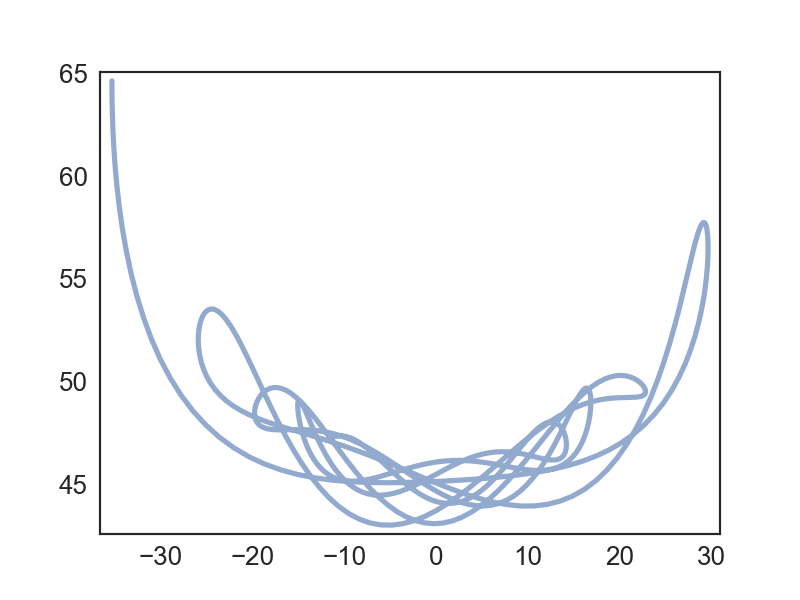

In [33]:
plot(system_source.results.x, system_source.results.y)

In [34]:
def update_doppler(x_source, y_source, vx_source, vy_source, x_observer, y_observer, vx_observer, vy_observer):
    
    S = Vector(x_source, y_source)
    R = Vector(x_observer, y_observer)
    
    v_source = Vector(vx_source, vy_source)
    v_observer = Vector(vx_observer, vy_observer)
    
    D = S - R
    D_hat = D.hat()
    
    v_dop_source = (v_source.x*D_hat.x) + (v_source.y*D_hat.y)
    v_dop_observer = v_observer.x*D_hat.x + v_observer.y*D_hat.y
    
    doppler_effect = (343 + v_dop_observer)/(343 + v_dop_source)
    
    return doppler_effect

In [35]:
#TEST
update_doppler(0,0, 0,0, 20, 0, -10,0)

<Quantity(1.0291545189504374, 'dimensionless')>

In [36]:
def doppler(system_source, system_observer):
    
    series = TimeSeries()
    
    for i in system_source.results.index:
     
        x_source = system_source.results.x.loc[i] 
        y_source = system_source.results.y.loc[i] 
        vx_source = system_source.results.vx.loc[i]
        vy_source = system_source.results.vy.loc[i]
        x_observer = system_observer.results.x.loc[i]
        y_observer = system_observer.results.y.loc[i]
        vx_observer = system_observer.results.vx.loc[i]
        vy_observer = system_observer.results.vy.loc[i]
        

        
        doppler_effect = update_doppler(x_source, y_source, vx_source, vy_source, x_observer, y_observer, vx_observer, vy_observer)
        series[i] = doppler_effect
    return series
        
        

In [37]:
doppler_series = doppler(system_source=system_source, system_observer=system_observer)

<IPython.core.display.Javascript object>


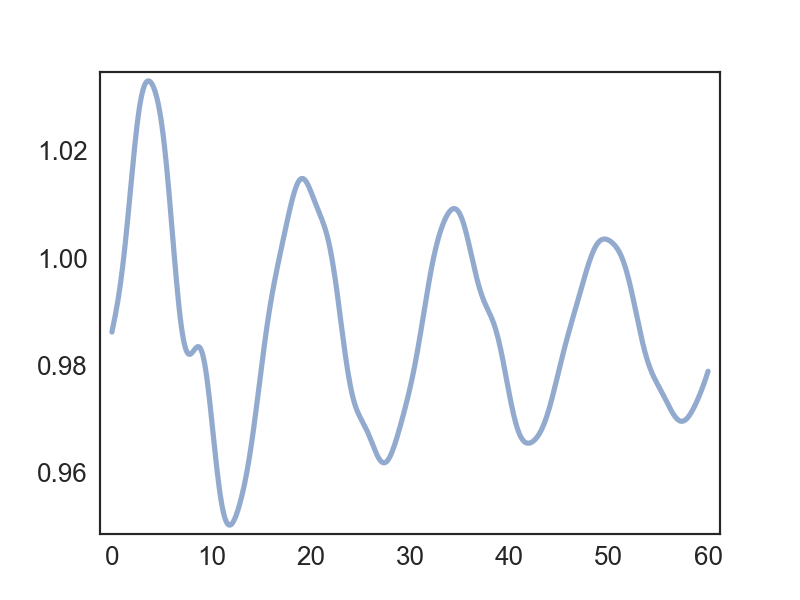

In [38]:
newfig()
plot(doppler_series)

In [39]:
doppler_series

,value
0.00,0.9862014603337145 dimensionless
0.12,0.987287788319382 dimensionless
0.24,0.9883920207467912 dimensionless
0.36,0.9895387332520652 dimensionless
0.48,0.9907511438502581 dimensionless
0.60,0.9920501716313517 dimensionless
0.72,0.9934535770100095 dimensionless
0.84,0.9949752090547029 dimensionless
0.96,0.996624375491666 dimensionless
1.08,0.9984053500950274 dimensionless


In [40]:
def cost_func(system_source, system_observer):
    
    doppler_series = doppler(system_source, system_observer)
    
    total_cost = 0 
    
    for i in doppler_series:
        
        cost = abs(1200*(log(i)/log(2)))
       # print(type(i))
#         print(log(i, 2))
#         cost = abs(1200 * log(i, 2))
#       print(i)
        total_cost += cost
    
    
        
        
    return total_cost
        
    

In [41]:
cost_func(system_source, system_observer)

16639.535718825005

In [45]:
def sweep_k(k_min, k_max, step):
    series = SweepSeries()
    condition_observer = Condition(x = 150,
                              y =  1.5, b=0, c=0, d=0, v_init= 5, duration = 60)
    
    for i in linrange(k_min, k_max, step):
        condition_source = Condition(height = 100,
                               g = 9.8,
                               mass = 1.85,
                               area = 0.038,
                               rho = 1.2,
                               v_term = 45,
                               duration = 60,
                               length = 50,
                               angle = (270 - 45) * degree,
                               k = i)
        system_source = make_system_source(condition_source)
        system_observer = make_system_observer(condition_observer)
        
        run_odeint(system_source, slope_func_source)
        run_odeint(system_observer, slope_func_observer)
        
        cost = cost_func(system_source=system_source, system_observer= system_observer)
        
        series[i] = cost
    return series


    
        

In [46]:
results_sweep_k = sweep_k(1, 30, 1)

<IPython.core.display.Javascript object>


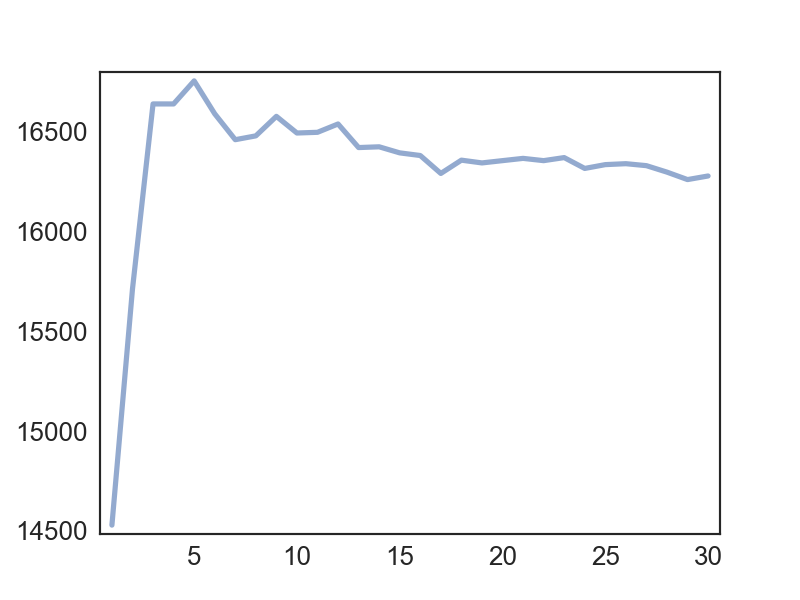

In [47]:
newfig()

plot(results_sweep_k)

In [50]:
def sweep_mass(minimum, maximum, num_steps):
    series = SweepSeries()
    condition_observer = Condition(x = 150,
                              y =  1.5, b=0, c=0, d=0, v_init= 5, duration = 60)
    
    for i in linrange(minimum, maximum, num_steps):
        condition_source = Condition(height = 100,
                               g = 9.8,
                               mass = i,
                               area = 0.038,
                               rho = 1.2,
                               v_term = 45,
                               duration = 60,
                               length = 50,
                               angle = (270 - 45) * degree,
                               k = 4)
        system_source = make_system_source(condition_source)
        system_observer = make_system_observer(condition_observer)
        
        run_odeint(system_source, slope_func_source)
        run_odeint(system_observer, slope_func_observer)
        
        cost = cost_func(system_source=system_source, system_observer= system_observer)
        
        series[i] = cost
    return series


    

In [51]:
def sweep_car_velocity(minimum, maximum, num_steps):
    series = SweepSeries()
    
    
    condition_source = Condition(height = 100,
                               g = 9.8,
                               mass = 1.85,
                               area = 0.038,
                               rho = 1.2,
                               v_term = 45,
                               duration = 60,
                               length = 50,
                               angle = (270 - 45) * degree,
                               k = 4)
    
    for i in linrange(minimum, maximum, num_steps):
        condition_observer = Condition(x = 150,
                              y =  1.5, b=0, c=0, d=0, v_init= i, duration = 60)
        
        system_source = make_system_source(condition_source)
        system_observer = make_system_observer(condition_observer)
        
        run_odeint(system_source, slope_func_source)
        run_odeint(system_observer, slope_func_observer)
        
        cost = cost_func(system_source=system_source, system_observer= system_observer)
        
        series[i] = cost
    return series


In [40]:
results_sweep_car_velocity = sweep_car_velocity(0, 50, 10)

newfig()

plot(results_sweep_car_velocity)

<IPython.core.display.Javascript object>


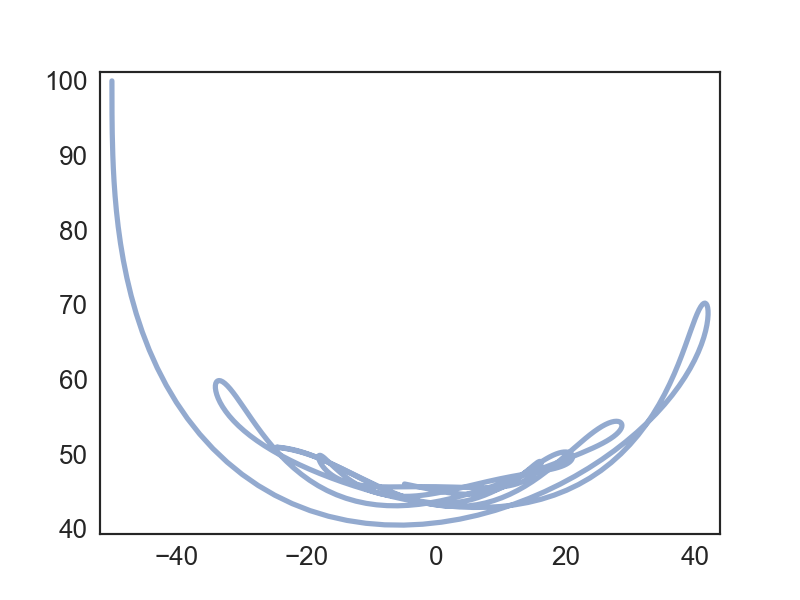

In [52]:
#CHANGING ANGLE

condition_source = Condition(height = 100,
                           g = 9.8,
                           mass = 1.85,
                           area = 0.038,
                           rho = 1.2,
                           v_term = 45,
                           duration = 60,
                           length = 50,
                           angle = (270 - 90) * degree,
                           k = 4)

system_source = make_system_source(condition_source)

run_odeint(system_source, slope_func_source)

newfig()

plot(system_source.results.x, system_source.results.y)

<IPython.core.display.Javascript object>


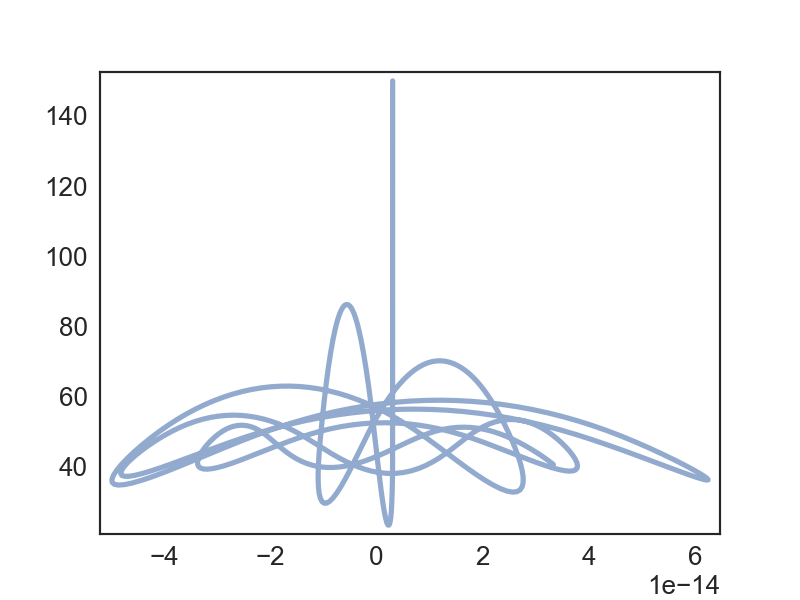

In [53]:
#CHANGING ANGLE

condition_source = Condition(height = 100,
                           g = 9.8,
                           mass = 1.85,
                           area = 0.038,
                           rho = 1.2,
                           v_term = 45,
                           duration = 60,
                           length = 50,
                           angle = (270 - 180) * degree,
                           k = 4)

system_source = make_system_source(condition_source)

newfig()

run_odeint(system_source, slope_func_source)
plot(system_source.results.x, system_source.results.y)

<IPython.core.display.Javascript object>


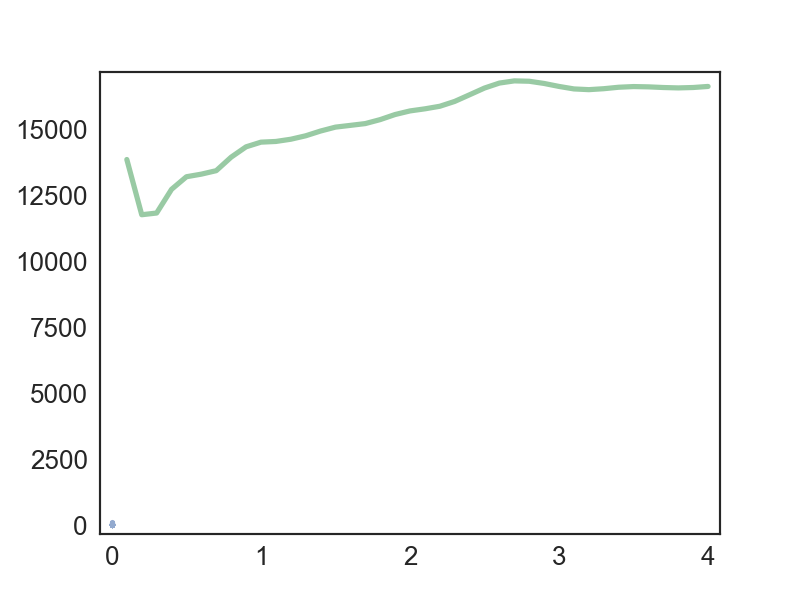

In [54]:

newfig()
plot(system_source.results.x, system_source.results.y)

In [55]:
def sweep_angle(minimum, maximum, num_steps):
    series = SweepSeries()
    condition_observer = Condition(x = 150,
                              y =  1.5, b=0, c=0, d=0, v_init= 5, duration = 60)
    
    for i in linrange(minimum, maximum, num_steps):
        condition_source = Condition(height = 100,
                               g = 9.8,
                               mass = 1.85,
                               area = 0.038,
                               rho = 1.2,
                               v_term = 45,
                               duration = 60,
                               length = 50,
                               angle = (270 - i) * degree,
                               k = 4)
        system_source = make_system_source(condition_source)
        system_observer = make_system_observer(condition_observer)
        
        run_odeint(system_source, slope_func_source)
        run_odeint(system_observer, slope_func_observer)
        
        cost = cost_func(system_source=system_source, system_observer= system_observer)
        
        series[i] = cost
    return series


    

In [56]:
k_sweep = sweep_k(k_max= 4, k_min= 0.1, step=0.1)

<IPython.core.display.Javascript object>


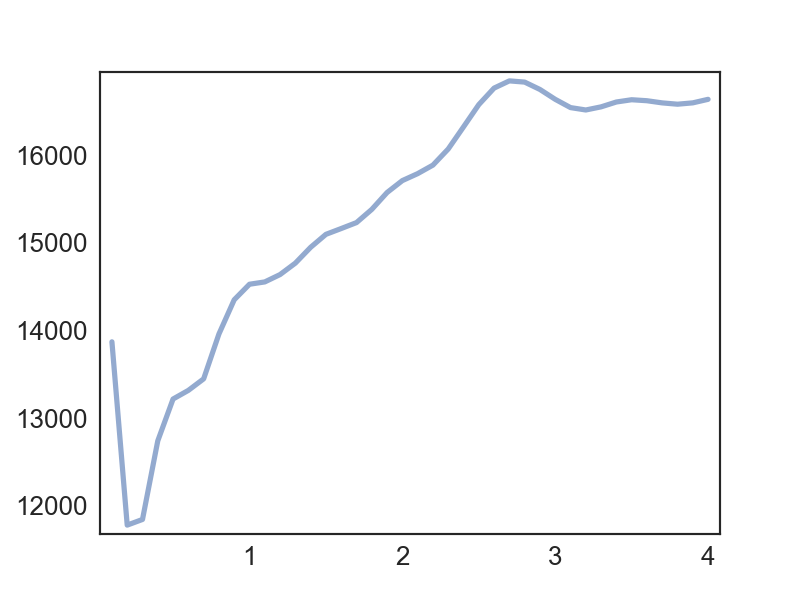

In [58]:
newfig()
plot(k_sweep)